### <font color='#A52A2A'> 1. Process Explanation

Among the different feature extraction methods, our main focus is on **MFCCs** (Mel-Frequency Cepstral Coefficients). We use the first **13** coefficients because they describe the spectral envelope, which carries the most important information for distinguishing different sounds.

For each coefficient, we compute its **mean value** across all time frames, giving us a stable summary of the audio signal.

Since our goal is to separate **car sounds** from **tram sounds**, we add a few more features that capture useful acoustic differences:

**Spectral Centroid:** Shows how “bright” a sound is. Tram sounds usually have more metallic and high-frequency content, which leads to a higher spectral centroid than cars.

**RMS Energy:** Measures the overall loudness of the signal. Trams tend to produce more steady and powerful sound energy, while cars vary more in intensity, so RMS helps highlight this difference.

**Zero Crossing Rate (ZCR):** Indicates how frequently the signal changes sign, which relates to noisiness and high-frequency content. Trams often include more sharp and metallic components, making ZCR a useful discriminator.

### <font color='#A52A2A'> 2. Import 

In [177]:
!pip install pandas

In [229]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### <font color='#A52A2A'> 3. Help Functions
#### <font color='#A52A2A'> 3. 1: Feature Extraction

**Feature extraction was performed using Mel-frequency Cepstral Coefficients (MFCCs), Spectral Centroid, Root Mean Square (RMS) energy, and Zero Crossing Rate (ZCR).**

In [317]:
def features_(y, sr):
    features = []
    
    # 1- MFCC (13 mean + 0 std = 13 features)
    mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfcc_features, axis=1))      # 13 coefficients
    

    # 2- Spectral Centroid (mean  = 1 features)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(centroid))          # 1 feature
        
    # 3- RMS (mean  = 1 features)
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))               # 1 feature
        
    # 4- Zero Crossing Rate (1 feature)
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr)) # 1 feature
        
    return np.array(features) 


def extract_features(file_paths):
    """
    Extract features from one or multiple audio files
    
    Parameters:
    - file_paths: single file path (str) or list of file paths
    
    Returns:
    - numpy array of shape (n_files, 31) for multiple files
    - numpy array of shape (31,) for single file
    """
    
    # Handle single file path
    if isinstance(file_paths, str):
        y, sr = librosa.load(file_paths, sr = 22050) #, sr=22050
        return features_(y, sr)
    
    # Handle multiple files
    result = []
    for file_path in file_paths:
        y, sr = librosa.load(file_path, sr=22050)  #, sr=22050
        features = features_(y, sr)
        result.append(features)
    
    return np.array(result)

def load_dataset(data_folder):
    features = []
    labels = []
    
    for class_name in ['car', 'tram']:
        class_folder = os.path.join(data_folder, class_name)
        
        if not os.path.exists(class_folder):
            print(f"⚠️ Warning: Missing class folder '{class_folder}'. Skipping this class.")
            continue # Skip to the next class
            
        for audio_file in os.listdir(class_folder):
            if audio_file.endswith('.wav'):
                file_path = os.path.join(class_folder, audio_file)
                feature_vector = extract_features(file_path)
                
                if feature_vector is not None:
                    features.append(feature_vector)
                    labels.append(0 if class_name == 'car' else 1)
    
    return np.array(features), np.array(labels)

#### <font color='#A52A2A'> 3. 2: Load Dataset

**Load all audio samples, extract their features, and return combined arrays of features and corresponding labels.**

#### <font color='#A52A2A'> 3. 3: Train the Dataset

**Using various machine learning models including:**
- SVM,
- KNN,
- Naive Bayes

In [318]:
def train_and_evaluate(model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    model_name: string → one of:
      "svm", "knn", "nb"
    """
    # Pre. Shuffling and normalize --------------------------------------
    X_train, y_train = shuffle(X_train, y_train, random_state=40)
    
    if model_name != "nb":
        # Scale for SVM, KNN, and MLP
        #scaler = MinMaxScaler()
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train_input = scaler.transform(X_train)
        X_val_input = scaler.transform(X_val)
        X_test_input = scaler.transform(X_test)
    else:
        # Pass the unscaled data for Naive Bayes
        X_train_input = X_train
        X_val_input = X_val
        X_test_input = X_test

    # 1. Create model based on name --------------------------------------
    if model_name == "svm":
        model = SVC(kernel="linear", probability=True)

    elif model_name == "knn":
        model = KNeighborsClassifier(n_neighbors=3)


    elif model_name == "nb":
        model = GaussianNB()


    else:
        raise ValueError(f"Unknown model name: {model_name}")


    # 2. Train on training data --------------------------------------
    model.fit(X_train_input, y_train)

    # 3. Evaluate on validation data --------------------------------------
    y_pred_val = model.predict(X_val_input)
    val_acc = accuracy_score(y_val, y_pred_val)

    # 4. Evaluate final performance on test data --------------------------------------
    y_pred_test = model.predict(X_test_input)

    test_acc = accuracy_score(y_test, y_pred_test)
    test_prec = precision_score(y_test, y_pred_test, pos_label=0)
    test_rec = recall_score(y_test, y_pred_test, pos_label=0)


    # Return everything
    result_df = pd.DataFrame([{
        "Model": model_name,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc,
        "Precision (car)": test_prec,
        "Recall (car)": test_rec
    }])

    return result_df, model


### <font color='#A52A2A'> 4. Execute the function and analyze the output.

#### <font color='#A52A2A'> 4. 1: Display the feature vector for the dimensions of the complete dataset.

In [319]:
DATA_PATH = "data"
X, y = load_dataset(DATA_PATH)
print(f"Dataset shape: {X.shape}")
print(f"Labels: {np.unique(y)}") 

Dataset shape: (573, 16)
Labels: [0 1]


In [320]:
# 1. Build feature names
feature_names = [f"mfcc_mean_{i}" for i in range(1, 14)]
feature_names += ["spectral_centroid_mean", "rms_mean", "zcr_mean"]

# 2. Convert dataset to DataFrame
df = pd.DataFrame(X, columns=feature_names)

In [347]:
car_sam = "data/car/836371__farnazdelirie__voice_14-11-2025_12_car.wav"
tram_sam = "data/tram/836330__farnazdelirie__voice_30-11-2025_2_tram.wav"

extract_features(car_sam), extract_features(tram_sam)

(array([-2.69644562e+02,  1.26951889e+02, -8.43317628e-01, -5.49348688e+00,
         8.48072243e+00,  8.67488670e+00,  3.52249861e+00, -9.00851727e-01,
         9.25324059e+00,  5.39016628e+00, -8.69637871e+00, -7.95401525e+00,
        -9.70919037e+00,  1.85233902e+03,  1.98332686e-02,  7.60470512e-02]),
 array([-1.28453232e+02,  1.40212662e+02, -1.22443676e+01, -5.55613220e-01,
        -3.63221097e+00, -8.14586818e-01, -6.16072321e+00, -1.52472410e+01,
        -7.09786510e+00, -6.88867950e+00, -1.62543261e+00, -5.87599468e+00,
        -1.40372801e+01,  1.53329134e+03,  8.75832140e-02,  6.54575362e-02]))

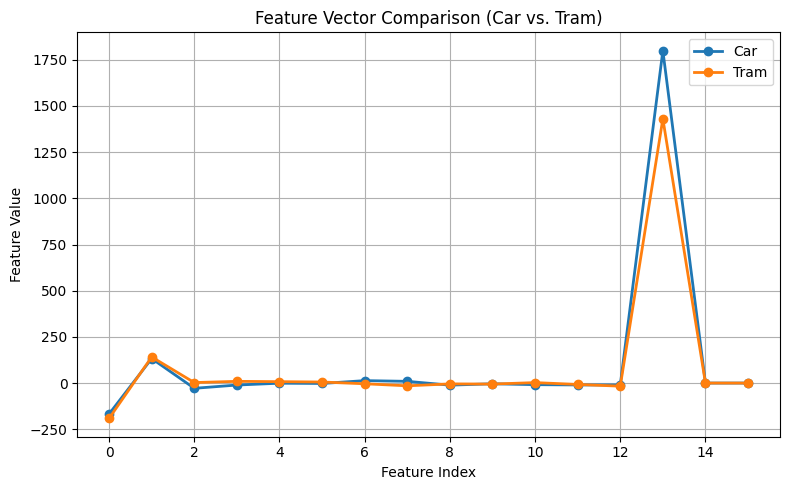

In [349]:
car_sam = "data/car/836360__farnazdelirie__voice_14-11-2025_2_car.wav"
tram_sam = "data/tram/836329__farnazdelirie__voice_22-11-2025_1_tram.wav"
plt.figure(figsize=(8, 5))

plt.plot(extract_features(car_sam), marker='o', label="Car", linewidth=2)
plt.plot(extract_features(tram_sam), marker='o', label="Tram", linewidth=2)

plt.title("Feature Vector Comparison (Car vs. Tram)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

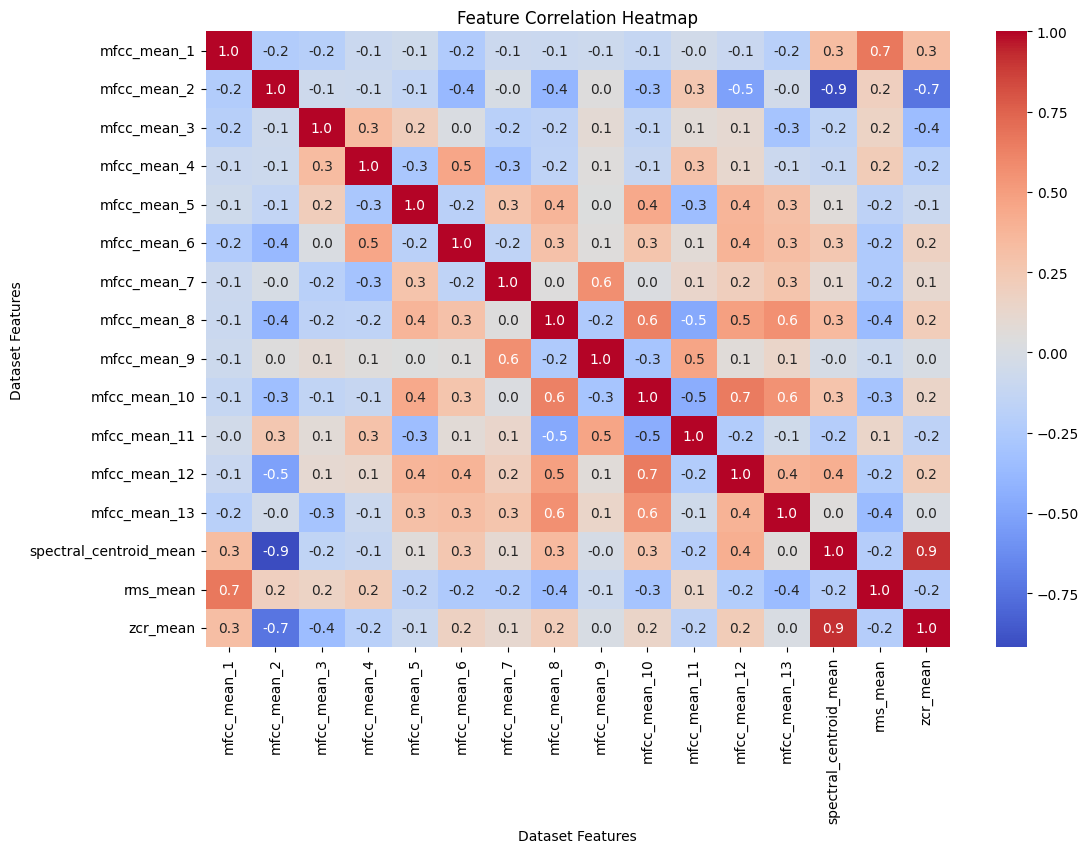

In [321]:
corr_matrix = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.xlabel("Dataset Features")
plt.ylabel("Dataset Features")
plt.show()

In [322]:
cols_to_remove = [0,15]
X_reduced = np.delete(X, cols_to_remove, axis=1)

In [323]:
sd = df.describe().T
sd[['mean', 'std', 'min', 'max']]

,mean,std,min,max
mfcc_mean_1,-212.154779,78.559172,-447.808075,-4.552491
mfcc_mean_2,132.578168,36.179834,45.558525,225.569565
mfcc_mean_3,-10.032860,24.690909,-80.443016,53.909985
mfcc_mean_4,17.102049,15.407511,-29.278635,64.783333
mfcc_mean_5,-6.628590,13.092795,-59.852787,22.238941
mfcc_mean_6,14.706567,11.149854,-14.414628,45.794830
mfcc_mean_7,0.513005,10.485750,-28.066175,34.155411
mfcc_mean_8,0.217726,11.462837,-29.577925,30.150377
mfcc_mean_9,2.312612,9.978243,-17.130268,33.670685
mfcc_mean_10,-1.916785,10.467383,-45.213779,21.340004


In [324]:
X_reduced = X

#### <font color='#A52A2A'> 4. 2: Split the data

**Partition the dataset with randomized shuffling to prevent ordering biases, utilize validation data for training monitoring, and implement random seed initialization for result reproducibility.**

In [325]:
X_train, X_temp, y_train, y_temp = train_test_split(X_reduced, y, test_size=0.30, shuffle=True, stratify=y, random_state=40)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=True, stratify=y_temp, random_state=40)

In [326]:
# Print all splits for complete verification
print("=== DATA SPLIT VERIFICATION ===")
print(f"Original data: X {X.shape}, y {y.shape}")
print(f"Train data:    X {X_train.shape}, y {y_train.shape} which is {len(X_train)/len(X)*100:.1f}% of whole data")
print(f"Validation:    X {X_val.shape}, y {y_val.shape} which is {len(X_val)/len(X)*100:.1f}% of whole data")
print(f"Test data:     X {X_test.shape}, y {y_test.shape} which is {len(X_test)/len(X)*100:.1f}% of whole data")

# Verify they sum to 100%
total_percent = (len(X_train) + len(X_val) + len(X_test)) / len(X) * 100
print(f"\nTotal: {total_percent:.1f}%")

# Verify class distribution
print("\n=== CLASS DISTRIBUTION ===")
print(f"Original - Car: {(y == 0).mean()*100:.1f}%, Tram: {(y == 1).mean()*100:.1f}%")
print(f"Train    - Car: {(y_train == 0).mean()*100:.1f}%, Tram: {(y_train == 1).mean()*100:.1f}%")
print(f"Val      - Car: {(y_val == 0).mean()*100:.1f}%, Tram: {(y_val == 1).mean()*100:.1f}%")
print(f"Test     - Car: {(y_test == 0).mean()*100:.1f}%, Tram: {(y_test == 1).mean()*100:.1f}%")


=== DATA SPLIT VERIFICATION ===
Original data: X (573, 16), y (573,)
Train data:    X (401, 16), y (401,) which is 70.0% of whole data
Validation:    X (86, 16), y (86,) which is 15.0% of whole data
Test data:     X (86, 16), y (86,) which is 15.0% of whole data

Total: 100.0%

=== CLASS DISTRIBUTION ===
Original - Car: 51.5%, Tram: 48.5%
Train    - Car: 51.4%, Tram: 48.6%
Val      - Car: 51.2%, Tram: 48.8%
Test     - Car: 52.3%, Tram: 47.7%


#### <font color='#A52A2A'> 4. 3: Execute model training and conduct comprehensive performance comparison across all algorithms.

In [327]:
all_results = []  
model_names = []
trained_models = []

models = ["svm", "knn", "nb"]

for ml in models:
    table, model_obj = train_and_evaluate(
        ml,
        X_train, y_train,
        X_val, y_val,
        X_test, y_test
    )
    all_results.append(table)
    trained_models.append(model_obj)
    model_names.append(ml.upper())

# Combine all results into one big table
final_table = pd.concat(all_results, ignore_index=True)

print(final_table)

  Model  Validation Accuracy  Test Accuracy  Precision (car)  Recall (car)
0   svm             0.941860       0.906977         0.893617      0.933333
1   knn             0.988372       0.988372         0.978261      1.000000
2    nb             0.848837       0.872093         0.854167      0.911111
